# Tutorial 04: Hierarchical Functions

*Authors: Zach del Rosario*

---

This is a tutorial on using a hierarchical structure to decompose complicated functions into simpler pieces. We will use [*directed acyclic graphs*](https://en.wikipedia.org/wiki/Directed_acyclic_graph) to represent functions with subfunctions. The grama language allows us to **easily** define and visualize this graph structure.

**Learning Goals**: By completing this notebook, you will learn:
1. How to define a hierarchical function
1. How to visualize the hierarchical structure
1. The advantages---and disadvantages---of function decomposition

**Prerequisites**:
- Familiarity with the Python programming language
- [Tutorial 03: Model Building](https://github.com/zdelrosario/py_grama/blob/master/tutorials/t03_building_assignment.ipynb)

**Table of Contents**:
1. [Defining hierarchical functions](#s1)
1. [Debugging the build process](#s2)
1. [Using the hierarchical function](#3)


## Defining hierarchical functions <a id="s1"></a>

---

As a running example, we will again study the plate buckling model discussed in [Tutorial 03: Model Building](https://github.com/zdelrosario/py_grama/blob/master/tutorials/t03_building_assignment.ipynb). For reference, the *function* from that model was

$$g_{\text{buckling}} = \frac{\pi E}{12 (1 - \mu^2)} \left(\frac{t}{h}\right)^2 - \frac{L}{wt}.$$

We are going to *decompose* $g_{\text{buckling}}$ into simpler pieces, in order to organize and study the components of this function. Re-define the limit state as

$$g_{\text{buckling}} = \sigma_{\text{critical}} - \sigma_{\text{applied}},$$

where

$$\sigma_{\text{critical}} = \frac{\pi E}{12 (1 - \mu^2)} \left(\frac{t}{h}\right)^2$$

is the *critical buckling stress*. It represents the strength of the plate---the capacity of the structure to take load. The term

$$\sigma_{\text{applied}} = \frac{L}{wt}$$

is the *applied stress*. This is the demand placed on the structure due to the loading conditions.

We can think of $\sigma_{\text{critical}}, \sigma_{\text{applied}}$ as *intermediate outputs*---they are outputs of the model, but also *inputs* to functions *within the model*.


#### __Q1: Build with subfunctions__

For convenience, I've implemented the three subfunctions below. Your task is to assemble these functions using grama to form one hierarchically-defined model.


In [1]:
###
# TASK: Set up grama, build the model
# TODO: Import grama, build a model with the three sub-functions
###

# -- NO NEED TO MODIFY BELOW ----
# The three functions and their inputs / outputs
def fun_critical(x):
    E, mu, t, h = x
    return 3.1415 * E / (12 * (1 - mu)**2) * (t / h)**2
var_critical = ["E", "mu", "t", "h"]
out_critical = ["sig_cr"]

def fun_applied(x):
    L, w, t = x
    return L / w / t
var_applied = ["L", "w", "t"]
out_applied = ["sig_app"]

def fun_limit(x):
    sig_cr, sig_app= x
    return sig_cr - sig_app
var_limit = ["sig_cr", "sig_app"]
out_limit = ["g_buckle"]

# TODO: Import grama
# TODO: Build and assign the model to variable `md`


# -- NO NEED TO MODIFY BELOW ----
# Summarize the model
md.printpretty()

model: Buckling plate

  inputs:
    var_det:
      L: (unbounded)
      t: (unbounded)
      E: (unbounded)
      h: (unbounded)
      w: (unbounded)
      mu: (unbounded)
    var_rand:
    copula:
        None
  functions:
    Critical: ['E', 'mu', 't', 'h'] -> ['sig_cr']
    Applied: ['L', 'w', 't'] -> ['sig_app']
    Limit State: ['sig_cr', 'sig_app'] -> ['g_buckle']


Once you've successfully implemented the function, you will be able to *visualize* the hierarchical function as a *directed acyclic graph* **automagically**. 

Run the following to visualize your function.


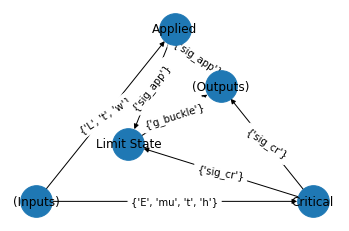

In [2]:
# -- NO NEED TO MODIFY BELOW ----
# Visualize the hierarchical function
md.show_dag()

What's a **directed acyclic graph** (DAG)?

- This is a **graph** because it has nodes (the circles) and edges (the lines between circles)
- It's **directed** because the edges have one-way arrows
- It's **acyclic** because the directed edges are not oriented in loops

In this graph the **nodes represent the full set of `(Inputs)`, the full set of `(Outputs)`, and all the subfunctions**, while the **edges represent sets of variables / outputs**. You can think of the `(Inputs)` and `(Outputs)` as the two "sides" of the function, and the subfunctions as the particulars of how information flows from one side to the other.

Practically, this DAG tells us which inputs go to which sub-functions. The directed edges are labeled with variables; for instance, the `Critical` function takes as inputs `{t, mu, E, h}`, and returns `{sig_cr}`. Then `{sig_cr}` goes both to the `Limit State`, and to the `(Outputs)`. We can also see that the `Limit State` does not *directly* depend on any of the inputs; all inputs are summarized before they enter the limit state function.

This DAG is useful for a couple reasons:

1. It gives us a quick overview of which outputs depend on which inputs
1. It helps us debug potential model problems

We'll do a lot of hierarchical function debugging in the following section!


## Debugging the build process <a id="s2"></a>

---

I purposefully laid out the functions above in a *special* order[<sup>1</sup>](#fn1); what happens if we mess with that order? Or what if you're building a hierarchical function from scratch and are not yet sure what the *special* order is? Here we'll learn how to *debug* building a hierarchical function by dealing with some common problems you may run into.


#### __Q2: Fix this code__

The following implementation of the same model is *almost* correct. Uncomment the code, read the error message for a hint on what's wrong, and  fix the code.

*Hint*: Order of the functions *matters*.


In [3]:
###
# TASK: Fix this code
# TODO: Uncomment and execute the following code; the error message
#       will give you a hint about how to fix it.
###

# -- UNCOMMENT BELOW AND RUN----
# TODO: Fix this!
# gr.Model("Wrong!") >> \
#     gr.cp_function(
#         fun=fun_limit,
#         var=var_limit,
#         out=out_limit,
#         name="Limit State"
#     ) >> \
#     gr.cp_function(
#         fun=fun_critical,
#         var=var_critical,
#         out=out_critical,
#         name="Critical"
#     ) >> \
#     gr.cp_function(
#         fun=fun_applied,
#         var=var_applied,
#         out=out_applied,
#         name="Applied"
#     )


If you scroll to the bottom of the error, you should see

```
ValueError: `out` must not intersect model.var
```

along with some hints about how to fix the error. This illustrates our first *rule* about building hierarchical functions:

__Hierarchical Functions Rule 1:__ Build from inputs to outputs

Under the hood, grama checks that inputs are not being re-defined as outputs. *If you want to have an intermediate output for re-use in another function, you need to define it as an output first.* We can say this more succinctly as "build from inputs to outputs".

For example, the code immediately above tried to define the `Limit State` function before `sig_cr` and `sig_app` were available; thus grama thought these were inputs. 

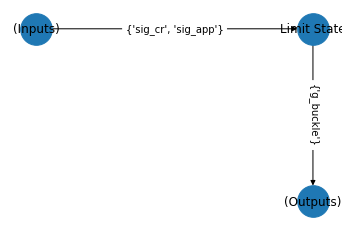

In [4]:
md_tmp = gr.Model("Limit state only") >> \
    gr.cp_function(
        fun=fun_limit,
        var=var_limit,
        out=out_limit,
        name="Limit State"
    )
md_tmp.show_dag()

However, `{sig_app, sig_cr}` are not *really* inputs; they're intermediate outputs. We need to provide them by first defining the `Critical` and `Applied` functions first.


#### __Q3: Fix this code__




In [5]:
###
# TASK: Fix this code
# TODO: Uncomment and execute the following code; the error message
#       will give you a hint about how to fix it.
###

# -- UNCOMMENT BELOW AND RUN----
# TODO: Fix this!
# md = gr.Model("Also wrong!") >> \
#     gr.cp_function(
#         fun=fun_critical,
#         var=var_critical,
#         out=["sig"],
#         name="Critical"
#     ) >> \
#     gr.cp_function(
#         fun=fun_applied,
#         var=var_applied,
#         out=["sig"],
#         name="Applied"
#     ) >> \
#     gr.cp_function(
#         fun=fun_limit,
#         var=var_limit,
#         out=out_limit,
#         name="Limit State"
#     )


If you scroll to the bottom of the error, you should see

```
ValueError: `out` must not intersect model.out
```

along with some hints about how to fix the error. The error is much like the previous, except that this version talkes about `outputs` only. This illustrates our second *rule* about building hierarchical functions:

__Hierarchical Functions Rule 2:__ Use unique output names

Different functions may take the same input, so re-using these names is fine. However, having multiple sources for the same output is ambiguous. Grama automatically detects cases like this and throws an error.

For example, the code immediately above used `sig` for both the critical and applied stresses. The `Applied` function essentially tried to override the `Critical` function's output. This caused an error.


#### __Q4: Fix this code__

Not *all* building errors will throw error messages! Sometimes a *typo* will mess things up. In this case, showing the DAG will help you catch typos that are hard to see in the code. Use the DAG visualization to catch the typos below.


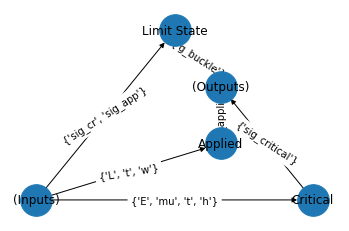

In [6]:
###
# TASK: Fix this code
# TODO: Plot the DAG for the function, and see if you can determine what went wrong.
#       Fix the code to correctly implement the model.
###

# TODO: Fix this code
md_wrong = gr.Model("Buckling plate") >> \
    gr.cp_function(
        fun=fun_critical,
        var=var_critical,
        out=["sig_critical"],
        name="Critical"
    ) >> \
    gr.cp_function(
        fun=fun_applied,
        var=var_applied,
        out=["sig_applied"],
        name="Applied"
    ) >> \
    gr.cp_function(
        fun=fun_limit,
        var=var_limit,
        out=out_limit,
        name="Limit State"
    )

# TODO: Visualize the DAG and inspect



Based on the DAG, we can see that `sig_cr, sig_app` go directly from `(Inputs)` to the `Limit State`, but we set out to decompose the limit state into sub-functions! This visual highlights the mistake: The intermediate output names were mis-spelled in the composition calls.


## Using the hierarchical function <a id="s3"></a>

---

Now that we've broken the limit state `g_buckle` into components, let's look at how we might use this decomposition to learn more about the model's behavior. Below I assign some bounds to the model and run a sinew analysis (see [t02](https://github.com/zdelrosario/py_grama/blob/master/tutorials/t02_explore_assignment.ipynb)) to inspect the input-to-output relations.

Calling plot_sinew_outputs....


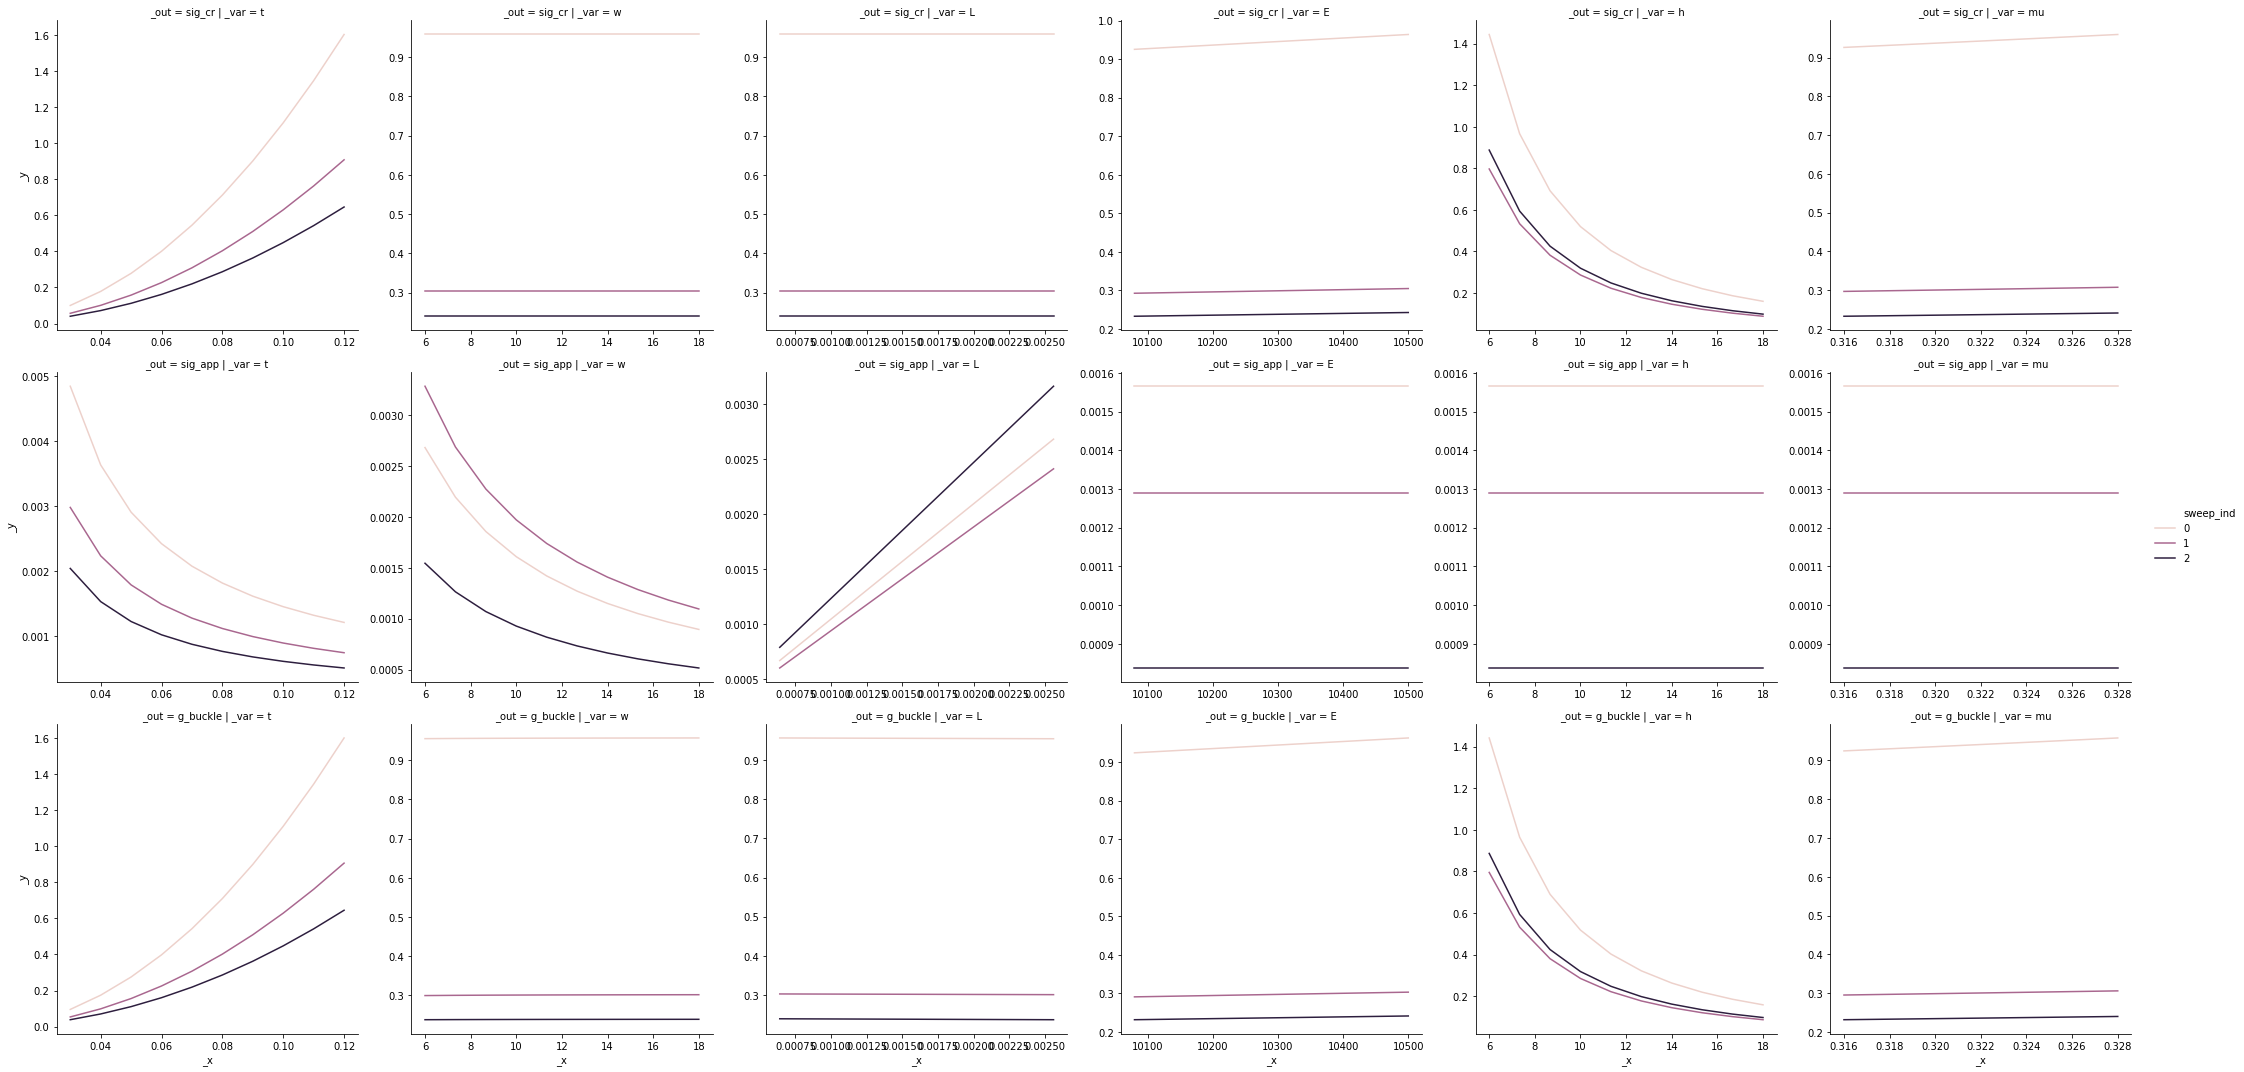

In [7]:
md_bounded = md >> \
    gr.cp_bounds(
        t=(0.03, 0.12),
        h=(6, 18),
        w=(6, 18),
        L=(6.4e-4, 2.56e-3),
        E=(1.008e4, 1.05e4),
        mu=(0.316, 0.328)
    )

md_bounded >> \
    gr.ev_sinews(df_det="swp") >> \
    gr.pt_auto()


Inspecting these results, we can see the model results are almost entirely determined by $\sigma_{\text{critical}}$, with minimal contributions coming from $\sigma_{\text{applied}}$.

*However*, it's not always a great idea to break a function down into more subfunctions. We could break the buckling model further into areas ($w * t$) and aspect ratios ($t / h$), but these intermediate values may clutter the outputs more than we need. Here are some reasons why you might want to decompose a function:

1. To study *competing terms* in a function (e.g. $\sigma_{\text{critical}}$ vs $\sigma_{\text{applied}}$)
1. When you have *data* on an *intermediate quantity*, and want to make a comparison

Ultimately, the implementation of the function (more generally, the whole model) should serve to help answer your scientific question. You may need to iterate to settle on a "correct" breakdown of subfunctions---you may find you don't need any subfunctions all!


__Footnotes__

<span id="fn1"><sup>1</sup> Specifically a <i>topological ordering</i>. It is a fact that a graph is a DAG if and only if it has a topological ordering. This is the special ordering that grama requires in function compositions.</span>